<a href="https://colab.research.google.com/github/hibameo/Email_Agent.langGraph/blob/main/Email_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
!pip -q install langchain-groq duckduckgo-search
!pip -q install -U langchain_community tiktoken langchainhub
!pip -q install -U langchain langgraph tavily-python

In [2]:
!pip show langgraph

Name: langgraph
Version: 0.2.73
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-sdk
Required-by: 


**The goal**

Reply to a customer email

get the email

categorize the email as a "sales", "custom enquiry", "off topic", "customer complaint"

use the category & initial email to create keywords for a search to research info needed for the reply

write a draft reply

check the reply

rewrite if needed

In [3]:
import os
from google.colab import userdata

os.environ["groq_api_key"] = userdata.get('groq_api_key_3')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY_1')

In [4]:
import os
from pprint import pprint

In [5]:
from langchain_groq import ChatGroq

GROQ_LLM = ChatGroq(
            model="llama3-70b-8192",
            api_key=os.environ.get("groq_api_key")
        )

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser

In [7]:
def write_markdown_file(content, filename):
  """Writes the given content as a markdown file to the local directory.

  Args:
    content: The string content to write to the file.
    filename: The filename to save the file as.
  """
  with open(f"{filename}.md", "w") as f:
    f.write(content)

# **Basic Chains**

Categorize EMAIL

Research Router

Search Keywords

Write Draft Email

Rewrite Router

Draft Email Analysis

Rewrite Email

In [8]:
#Categorize EMAIL
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a Email Categorizer Agent You are a master at understanding what a customer wants when they write an email and are able to categorize it in a useful way

     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Conduct a comprehensive analysis of the email provided and categorize into one of the following categories:
        price_equiry - used when someone is asking for information about pricing \
        customer_complaint - used when someone is complaining about something \
        product_enquiry - used when someone is asking for information about a product feature, benefit or service but not about pricing \\
        customer_feedback - used when someone is giving feedback about a product \
        off_topic when it doesnt relate to any other category \


            Output a single cetgory only from the types ('price_equiry', 'customer_complaint', 'product_enquiry', 'customer_feedback', 'off_topic') \
            eg:
            'price_enquiry' \

    EMAIL CONTENT:\n\n {initial_email} \n\n
    <|eot_id|>
    <|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["initial_email"],
)

email_category_generator = prompt | GROQ_LLM | StrOutputParser()

EMAIL = """HI there, \n
I am emailing to say that I had a wonderful stay at your resort last week. \n

I really appreaciate what your staff did

Thanks,
Hiba zaheer
"""

result = email_category_generator.invoke({"initial_email": EMAIL})

print(result)

'customer_feedback'


In [9]:
## Research Router
research_router_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an expert at reading the initial email and routing web search or directly to a draft email. \n

    Use the following criteria to decide how to route the email: \n\n

    If the initial email only requires a simple response
    Just choose 'draft_email'  for questions you can easily answer, prompt engineering, and adversarial attacks.
    If the email is just saying thank you etc then choose 'draft_email'

    You do not need to be stringent with the keywords in the question related to these topics. Otherwise, use research-info.
    Give a binary choice 'research_info' or 'draft_email' based on the question. Return the a JSON with a single key 'router_decision' and
    no premable or explaination. use both the initial email and the email category to make your decision
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Email to route INITIAL_EMAIL : {initial_email} \n
    EMAIL_CATEGORY: {email_category} \n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email","email_category"],
)

research_router = research_router_prompt | GROQ_LLM | JsonOutputParser()

email_category = 'customer_feedback'

print(research_router.invoke({"initial_email": EMAIL, "email_category":email_category}))

{'router_decision': 'draft_email'}


In [10]:
## Search keywords
search_keyword_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a master at working out the best keywords to search for in a web search to get the best info for the customer.

    given the INITIAL_EMAIL and EMAIL_CATEGORY. Work out the best keywords that will find the best
    info for helping to write the final email.

    Return a JSON with a single key 'keywords' with no more than 3 keywords and no premable or explaination.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_EMAIL: {initial_email} \n
    EMAIL_CATEGORY: {email_category} \n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email","email_category"],
)

search_keyword_chain = search_keyword_prompt | GROQ_LLM | JsonOutputParser()

email_category = 'customer_feedback'
research_info = None

print(search_keyword_chain.invoke({"initial_email": EMAIL, "email_category":email_category}))

{'keywords': ['hotel customer feedback', 'resort customer service', 'positive travel review']}


In [11]:
## Write Draft Email
draft_writer_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are the Email Writer Agent take the INITIAL_EMAIL below  from a human that has emailed our company email address, the email_category \
            that the categorizer agent gave it and the research from the research agent and \
            write a helpful email in a thoughtful and friendly way.

            If the customer email is 'off_topic' then ask them questions to get more information.
            If the customer email is 'customer_complaint' then try to assure we value them and that we are addressing their issues.
            If the customer email is 'customer_feedback' then try to assure we value them and that we are addressing their issues.
            If the customer email is 'product_enquiry' then try to give them the info the researcher provided in a succinct and friendly way.
            If the customer email is 'price_equiry' then try to give the pricing info they requested.

            You never make up information that hasn't been provided by the research_info or in the initial_email.
            Always sign off the emails in appropriate manner and from Hareem Zafar the Resident Manager.

            Return the email a JSON with a single key 'email_draft' and no premable or explaination.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_EMAIL: {initial_email} \n
    EMAIL_CATEGORY: {email_category} \n
    RESEARCH_INFO: {research_info} \n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email","email_category","research_info"],
)

draft_writer_chain = draft_writer_prompt | GROQ_LLM | JsonOutputParser()

email_category = 'customer_feedback'
research_info = None

print(draft_writer_chain.invoke({"initial_email": EMAIL, "email_category":email_category,"research_info":research_info}))

{'email_draft': "Dear Hiba Zaheer,\n\nThank you so much for taking the time to share your wonderful experience at our resort! We're thrilled to hear that our staff made a positive impact on your stay. Your kind words truly mean a lot to us, and we're grateful for guests like you who appreciate our efforts.\n\nWe'll make sure to pass on your appreciation to our team, as it's feedback like yours that motivates us to continue providing exceptional service.\n\nOnce again, thank you for your kind words, and we hope to welcome you back to our resort soon!\n\nBest regards,\nHareem Zafar, Resident Manager"}


In [12]:
## Rewrite Router
rewrite_router_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an expert at evaluating the emails that are draft emails for the customer and deciding if they
    need to be rewritten to be better. \n

    Use the following criteria to decide if the DRAFT_EMAIL needs to be rewritten: \n\n

    If the INITIAL_EMAIL only requires a simple response which the DRAFT_EMAIL contains then it doesn't need to be rewritten.
    If the DRAFT_EMAIL addresses all the concerns of the INITIAL_EMAIL then it doesn't need to be rewritten.
    If the DRAFT_EMAIL is missing information that the INITIAL_EMAIL requires then it needs to be rewritten.

    Give a binary choice 'rewrite' (for needs to be rewritten) or 'no_rewrite' (for doesn't need to be rewritten) based on the DRAFT_EMAIL and the criteria.
    Return the a JSON with a single key 'router_decision' and no premable or explaination. \
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_EMAIL: {initial_email} \n
    EMAIL_CATEGORY: {email_category} \n
    DRAFT_EMAIL: {draft_email} \n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email","email_category","draft_email"],
)

rewrite_router = rewrite_router_prompt | GROQ_LLM | JsonOutputParser()

email_category = 'customer_feedback'
draft_email = "You we can't help you, best regards Hiba zaheer"

print(rewrite_router.invoke({"initial_email": EMAIL, "email_category":email_category, "draft_email":draft_email}))

{'router_decision': 'rewrite'}


In [13]:
## Draft Email Analysis
draft_analysis_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are the Quality Control Agent read the INITIAL_EMAIL below  from a human that has emailed \
    our company email address, the email_category that the categorizer agent gave it and the \
    research from the research agent and write an analysis of how the email.

    Check if the DRAFT_EMAIL addresses the customer's issued based on the email category and the \
    content of the initial email.\n

    Give feedback of how the email can be improved and what specific things can be added or change\
    to make the email more effective at addressing the customer's issues.

    You never make up or add information that hasn't been provided by the research_info or in the initial_email.

    Return the analysis a JSON with a single key 'draft_analysis' and no premable or explaination.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_EMAIL: {initial_email} \n\n
    EMAIL_CATEGORY: {email_category} \n\n
    RESEARCH_INFO: {research_info} \n\n
    DRAFT_EMAIL: {draft_email} \n\n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email","email_category","research_info"],
)

draft_analysis_chain = draft_analysis_prompt | GROQ_LLM | JsonOutputParser()

email_category = 'customer_feedback'
research_info = None
draft_email = "Yo we can't help you, best regards Haniya"

email_analysis = draft_analysis_chain.invoke({"initial_email": EMAIL,
                                 "email_category":email_category,
                                 "research_info":research_info,
                                 "draft_email": draft_email})

pprint(email_analysis)

{'draft_analysis': {' Addresses_customer_issue': 'No',
                    'Changes_needed': "Remove the informal greeting 'Yo', add "
                                      'a personalized response thanking the '
                                      'customer for their feedback, and '
                                      'express appreciation for their stay at '
                                      'the resort.',
                    'Improvement_suggestions': 'The draft email does not '
                                               "acknowledge the customer's "
                                               'positive feedback or show '
                                               'appreciation for their stay at '
                                               'the resort. It should be '
                                               'rewritten to thank the '
                                               'customer for their feedback '
                                             

In [15]:
# Rewrite Email with Analysis
rewrite_email_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are the Final Email Agent read the email analysis below from the QC Agent \
    and use it to rewrite and improve the draft_email to create a final email.


    You never make up or add information that hasn't been provided by the research_info or in the initial_email.

    Return the final email as JSON with a single key 'final_email' which is a string and no premable or explaination.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    EMAIL_CATEGORY: {email_category} \n\n
    RESEARCH_INFO: {research_info} \n\n
    DRAFT_EMAIL: {draft_email} \n\n
    DRAFT_EMAIL_FEEDBACK: {email_analysis} \n\n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email",
                     "email_category",
                     "research_info",
                     "email_analysis",
                     "draft_email",
                     ],
)

rewrite_chain = rewrite_email_prompt | GROQ_LLM | JsonOutputParser()

email_category = 'customer_feedback'
research_info = None
draft_email = "Yo we can't help you, best regards Hiba"

final_email = rewrite_chain.invoke({"initial_email": EMAIL,
                                 "email_category":email_category,
                                 "research_info":research_info,
                                 "draft_email": draft_email,
                                "email_analysis":email_analysis})

final_email['final_email']

'Dear valued customer, thank you for taking the time to share your feedback about your stay at our resort. We appreciate your business and value your opinion. We are grateful for the opportunity to have served you and hope to have the pleasure of welcoming you back in the future. Best regards, Hiba'

tool setup

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=1)

Setting Up LangGraph **State**

In [17]:
from langchain.schema import Document
from langgraph.graph import END, StateGraph

In [18]:
from typing_extensions import TypedDict
from typing import List

### State

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        initial_email: email
        email_category: email category
        draft_email: LLM generation
        final_email: LLM generation
        research_info: list of documents
        info_needed: whether to add search info
        num_steps: number of steps
    """
    initial_email : str
    email_category : str
    draft_email : str
    final_email : str
    research_info : List[str]
    info_needed : bool
    num_steps : int
    draft_email_feedback : dict

# **Nodes**

categorize_email

research_info_search

draft_email_writer

analyze_draft_email

rewrite_email

no_rewrite

state_printer

In [19]:
def categorize_email(state):
    """take the initial email and categorize it"""
    print("---CATEGORIZING INITIAL EMAIL---")
    initial_email = state['initial_email']
    num_steps = int(state['num_steps'])
    num_steps += 1

    email_category = email_category_generator.invoke({"initial_email": initial_email})
    print(email_category)
    # save to local disk
    write_markdown_file(email_category, "email_category")

    return {"email_category": email_category, "num_steps":num_steps}

In [20]:
def research_info_search(state):

    print("---RESEARCH INFO SEARCHING---")
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    research_info = state["research_info"]
    num_steps = state['num_steps']
    num_steps += 1

    # Web search
    keywords = search_keyword_chain.invoke({"initial_email": initial_email,
                                            "email_category": email_category })
    keywords = keywords['keywords']
    # print(keywords)
    full_searches = []
    for keyword in keywords[:1]:
        print(keyword)
        temp_docs = web_search_tool.invoke({"query": keyword})
        web_results = "\n".join([d["content"] for d in temp_docs])
        web_results = Document(page_content=web_results)
        if full_searches is not None:
            full_searches.append(web_results)
        else:
            full_searches = [web_results]
    print(full_searches)
    print(type(full_searches))
    # write_markdown_file(full_searches, "research_info")
    return {"research_info": full_searches, "num_steps":num_steps}

In [21]:
def draft_email_writer(state):
    print("---DRAFT EMAIL WRITER---")
    ## Get the state
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    research_info = state["research_info"]
    num_steps = state['num_steps']
    num_steps += 1

    # Generate draft email
    draft_email = draft_writer_chain.invoke({"initial_email": initial_email,
                                     "email_category": email_category,
                                     "research_info":research_info})
    print(draft_email)
    # print(type(draft_email))

    email_draft = draft_email['email_draft']
    write_markdown_file(email_draft, "draft_email")

    return {"draft_email": email_draft, "num_steps":num_steps}

In [22]:
def analyze_draft_email(state):
    print("---DRAFT EMAIL ANALYZER---")
    ## Get the state
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    draft_email = state["draft_email"]
    research_info = state["research_info"]
    num_steps = state['num_steps']
    num_steps += 1

    # Generate draft email
    draft_email_feedback = draft_analysis_chain.invoke({"initial_email": initial_email,
                                                "email_category": email_category,
                                                "research_info":research_info,
                                                "draft_email":draft_email}
                                               )
    # print(draft_email)
    # print(type(draft_email))

    write_markdown_file(str(draft_email_feedback), "draft_email_feedback")
    return {"draft_email_feedback": draft_email_feedback, "num_steps":num_steps}

In [23]:
def rewrite_email(state):
    print("---ReWRITE EMAIL ---")
    ## Get the state
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    draft_email = state["draft_email"]
    research_info = state["research_info"]
    draft_email_feedback = state["draft_email_feedback"]
    num_steps = state['num_steps']
    num_steps += 1

    # Generate draft email
    final_email = rewrite_chain.invoke({"initial_email": initial_email,
                                                "email_category": email_category,
                                                "research_info":research_info,
                                                "draft_email":draft_email,
                                                "email_analysis": draft_email_feedback}
                                               )

    write_markdown_file(str(final_email), "final_email")
    return {"final_email": final_email['final_email'], "num_steps":num_steps}

In [24]:
def no_rewrite(state):
    print("---NO REWRITE EMAIL ---")
    ## Get the state
    draft_email = state["draft_email"]
    num_steps = state['num_steps']
    num_steps += 1

    write_markdown_file(str(draft_email), "final_email")
    return {"final_email": draft_email, "num_steps":num_steps}

In [25]:
def state_printer(state):
    """print the state"""
    print("---STATE PRINTER---")
    print(f"Initial Email: {state['initial_email']} \n" )
    print(f"Email Category: {state['email_category']} \n")
    print(f"Draft Email: {state['draft_email']} \n" )
    print(f"Final Email: {state['final_email']} \n" )
    print(f"Research Info: {state['research_info']} \n")
    print(f"Info Needed: {state['info_needed']} \n")  # Error occurs here
    print(f"Num Steps: {state['num_steps']} \n")
    return

In [26]:
def route_to_research(state):
    """
    Route email to web search or not.
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """

    print("---ROUTE TO RESEARCH---")
    initial_email = state["initial_email"]
    email_category = state["email_category"]


    router = research_router.invoke({"initial_email": initial_email,"email_category":email_category })
    print(router)
    # print(type(router))
    print(router['router_decision'])
    if router['router_decision'] == 'research_info':
        print("---ROUTE EMAIL TO RESEARCH INFO---")
        return "research_info"
    elif router['router_decision'] == 'draft_email':
        print("---ROUTE EMAIL TO DRAFT EMAIL---")
        return "draft_email"

In [27]:
def route_to_rewrite(state):

    print("---ROUTE TO REWRITE---")
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    draft_email = state["draft_email"]
    research_info = state["research_info"]

    # draft_email = "Yo we can't help you, best regards Hifza"

    router = rewrite_router.invoke({"initial_email": initial_email,
                                     "email_category":email_category,
                                     "draft_email":draft_email}
                                   )
    print(router)
    print(router['router_decision'])
    if router['router_decision'] == 'rewrite':
        print("---ROUTE TO ANALYSIS - REWRITE---")
        return "rewrite"
    elif router['router_decision'] == 'no_rewrite':
        print("---ROUTE EMAIL TO FINAL EMAIL---")
        return "no_rewrite"

# **Building Graph**

Nodes

In [28]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("categorize_email", categorize_email) # categorize email
workflow.add_node("research_info_search", research_info_search) # web search
workflow.add_node("state_printer", state_printer)
workflow.add_node("draft_email_writer", draft_email_writer)
workflow.add_node("analyze_draft_email", analyze_draft_email)
workflow.add_node("rewrite_email", rewrite_email)
workflow.add_node("no_rewrite", no_rewrite)

Edges

In [29]:
workflow.set_entry_point("categorize_email")

workflow.add_conditional_edges(
    "categorize_email",
    route_to_research,
    {
        "research_info": "research_info_search",
        "draft_email": "draft_email_writer",
    },
)
workflow.add_edge("research_info_search", "draft_email_writer")


workflow.add_conditional_edges(
    "draft_email_writer",
    route_to_rewrite,
    {
        "rewrite": "analyze_draft_email",
        "no_rewrite": "no_rewrite",
    },
)
workflow.add_edge("analyze_draft_email", "rewrite_email")
workflow.add_edge("no_rewrite", "state_printer")
workflow.add_edge("rewrite_email", "state_printer")
workflow.add_edge("state_printer", END)

In [ ]:
# Compile
app = workflow.compile()

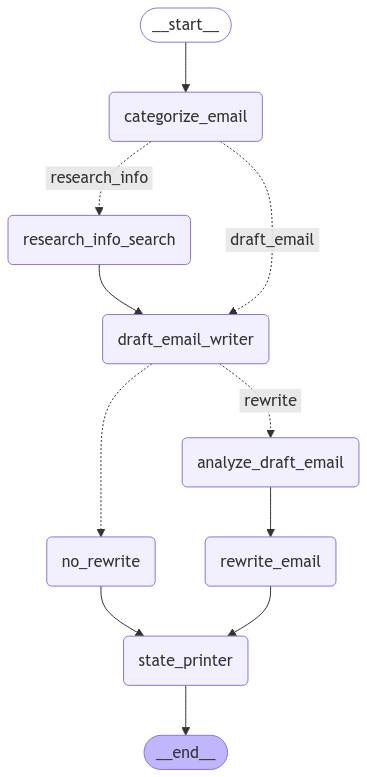

In [30]:
from IPython.display import Image, display
app = workflow.compile()

display(Image(app.get_graph(xray=1).draw_mermaid_png()))

In [31]:
# EMAIL = """HI there, \n
# I am emailing to find out the current price of Bitcoin. \n

# Can you please help me/

# Thanks,
# Haniya
# """

EMAIL = """HI there, \n
I am emailing to say that I had a wonderful stay at your resort last week. \n

I really appreaciate what your staff did

Thanks,
Haniya
"""

EMAIL = """HI there, \n
I am emailing to say that the resort weather was way to cloudy and overcast. \n
I wanted to write a song called 'Here comes the sun but it never came'

What should be the weather in Arizona in April?

I really hope you fix this next time.

Thanks,
sumbul
"""

# EMAIL = """HI there, \n
# Why can't I get to sing?

# Thanks,
# hiba
# """

# EMAIL = """HI there, \n
# Thanks for confirming my booking
# Thanks,
# Hiba
# "

In [32]:
# ipython-input-47-7b2dbdeca582
# run the agent
inputs = {"initial_email": EMAIL,"research_info": None, "num_steps":0, "info_needed": False} # Added info_needed
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")

---CATEGORIZING INITIAL EMAIL---
'customer_complaint'
---ROUTE TO RESEARCH---
{'router_decision': 'research_info'}
research_info
---ROUTE EMAIL TO RESEARCH INFO---
'Finished running: categorize_email:'
---RESEARCH INFO SEARCHING---
Arizona weather April
[Document(metadata={}, page_content="{'location': {'name': 'Arizona', 'region': 'Atlantida', 'country': 'Honduras', 'lat': 15.6333, 'lon': -87.3167, 'tz_id': 'America/Tegucigalpa', 'localtime_epoch': 1739801651, 'localtime': '2025-02-17 08:14'}, 'current': {'last_updated_epoch': 1739800800, 'last_updated': '2025-02-17 08:00', 'temp_c': 26.1, 'temp_f': 79.0, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 5.1, 'wind_kph': 8.3, 'wind_degree': 218, 'wind_dir': 'SW', 'pressure_mb': 1012.0, 'pressure_in': 29.88, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 89, 'cloud': 25, 'feelslike_c': 29.6, 'feelslike_f': 85.3, 'windchill_c': 24.3, 'windchill_f': 7

In [33]:
output = app.invoke(inputs)

print(output['final_email'])

---CATEGORIZING INITIAL EMAIL---
'customer_complaint'
---ROUTE TO RESEARCH---
{'router_decision': 'research_info'}
research_info
---ROUTE EMAIL TO RESEARCH INFO---
---RESEARCH INFO SEARCHING---
arizona april weather
[Document(metadata={}, page_content="{'location': {'name': 'Arizona', 'region': 'Atlantida', 'country': 'Honduras', 'lat': 15.6333, 'lon': -87.3167, 'tz_id': 'America/Tegucigalpa', 'localtime_epoch': 1739801651, 'localtime': '2025-02-17 08:14'}, 'current': {'last_updated_epoch': 1739800800, 'last_updated': '2025-02-17 08:00', 'temp_c': 26.1, 'temp_f': 79.0, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 5.1, 'wind_kph': 8.3, 'wind_degree': 218, 'wind_dir': 'SW', 'pressure_mb': 1012.0, 'pressure_in': 29.88, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 89, 'cloud': 25, 'feelslike_c': 29.6, 'feelslike_f': 85.3, 'windchill_c': 24.3, 'windchill_f': 75.7, 'heatindex_c': 26.6, 'heatindex_f

In [34]:
!cat /content/email_category.md

'customer_complaint'

In [35]:
!cat /content/draft_email.md

Dear Sumbul,

Thank you for reaching out to us about your experience with the resort weather. Sorry to hear that it was cloudy and overcast during your stay. 

Regarding your question about the weather in Arizona in April, our research suggests that the average temperature during this time is around 28.1°F (18/29°C). You can expect 12 hours of sunshine per day with occasional rainfall. 

We appreciate your feedback and would like to assure you that we value your opinion. We will take your concerns into consideration to improve our services for the future.

Thank you again for your email, and we hope to see you again soon.

Best regards,
Hareem Zafar,
Resident Manager